# Leveraging LangChain to Build a More Complex Document Querying Application

Now that we have some of the basics of LangChain under our belt - let's build a "full-suite" application.

We'll be working off of this diagram for the following exercise as a template to create our application!

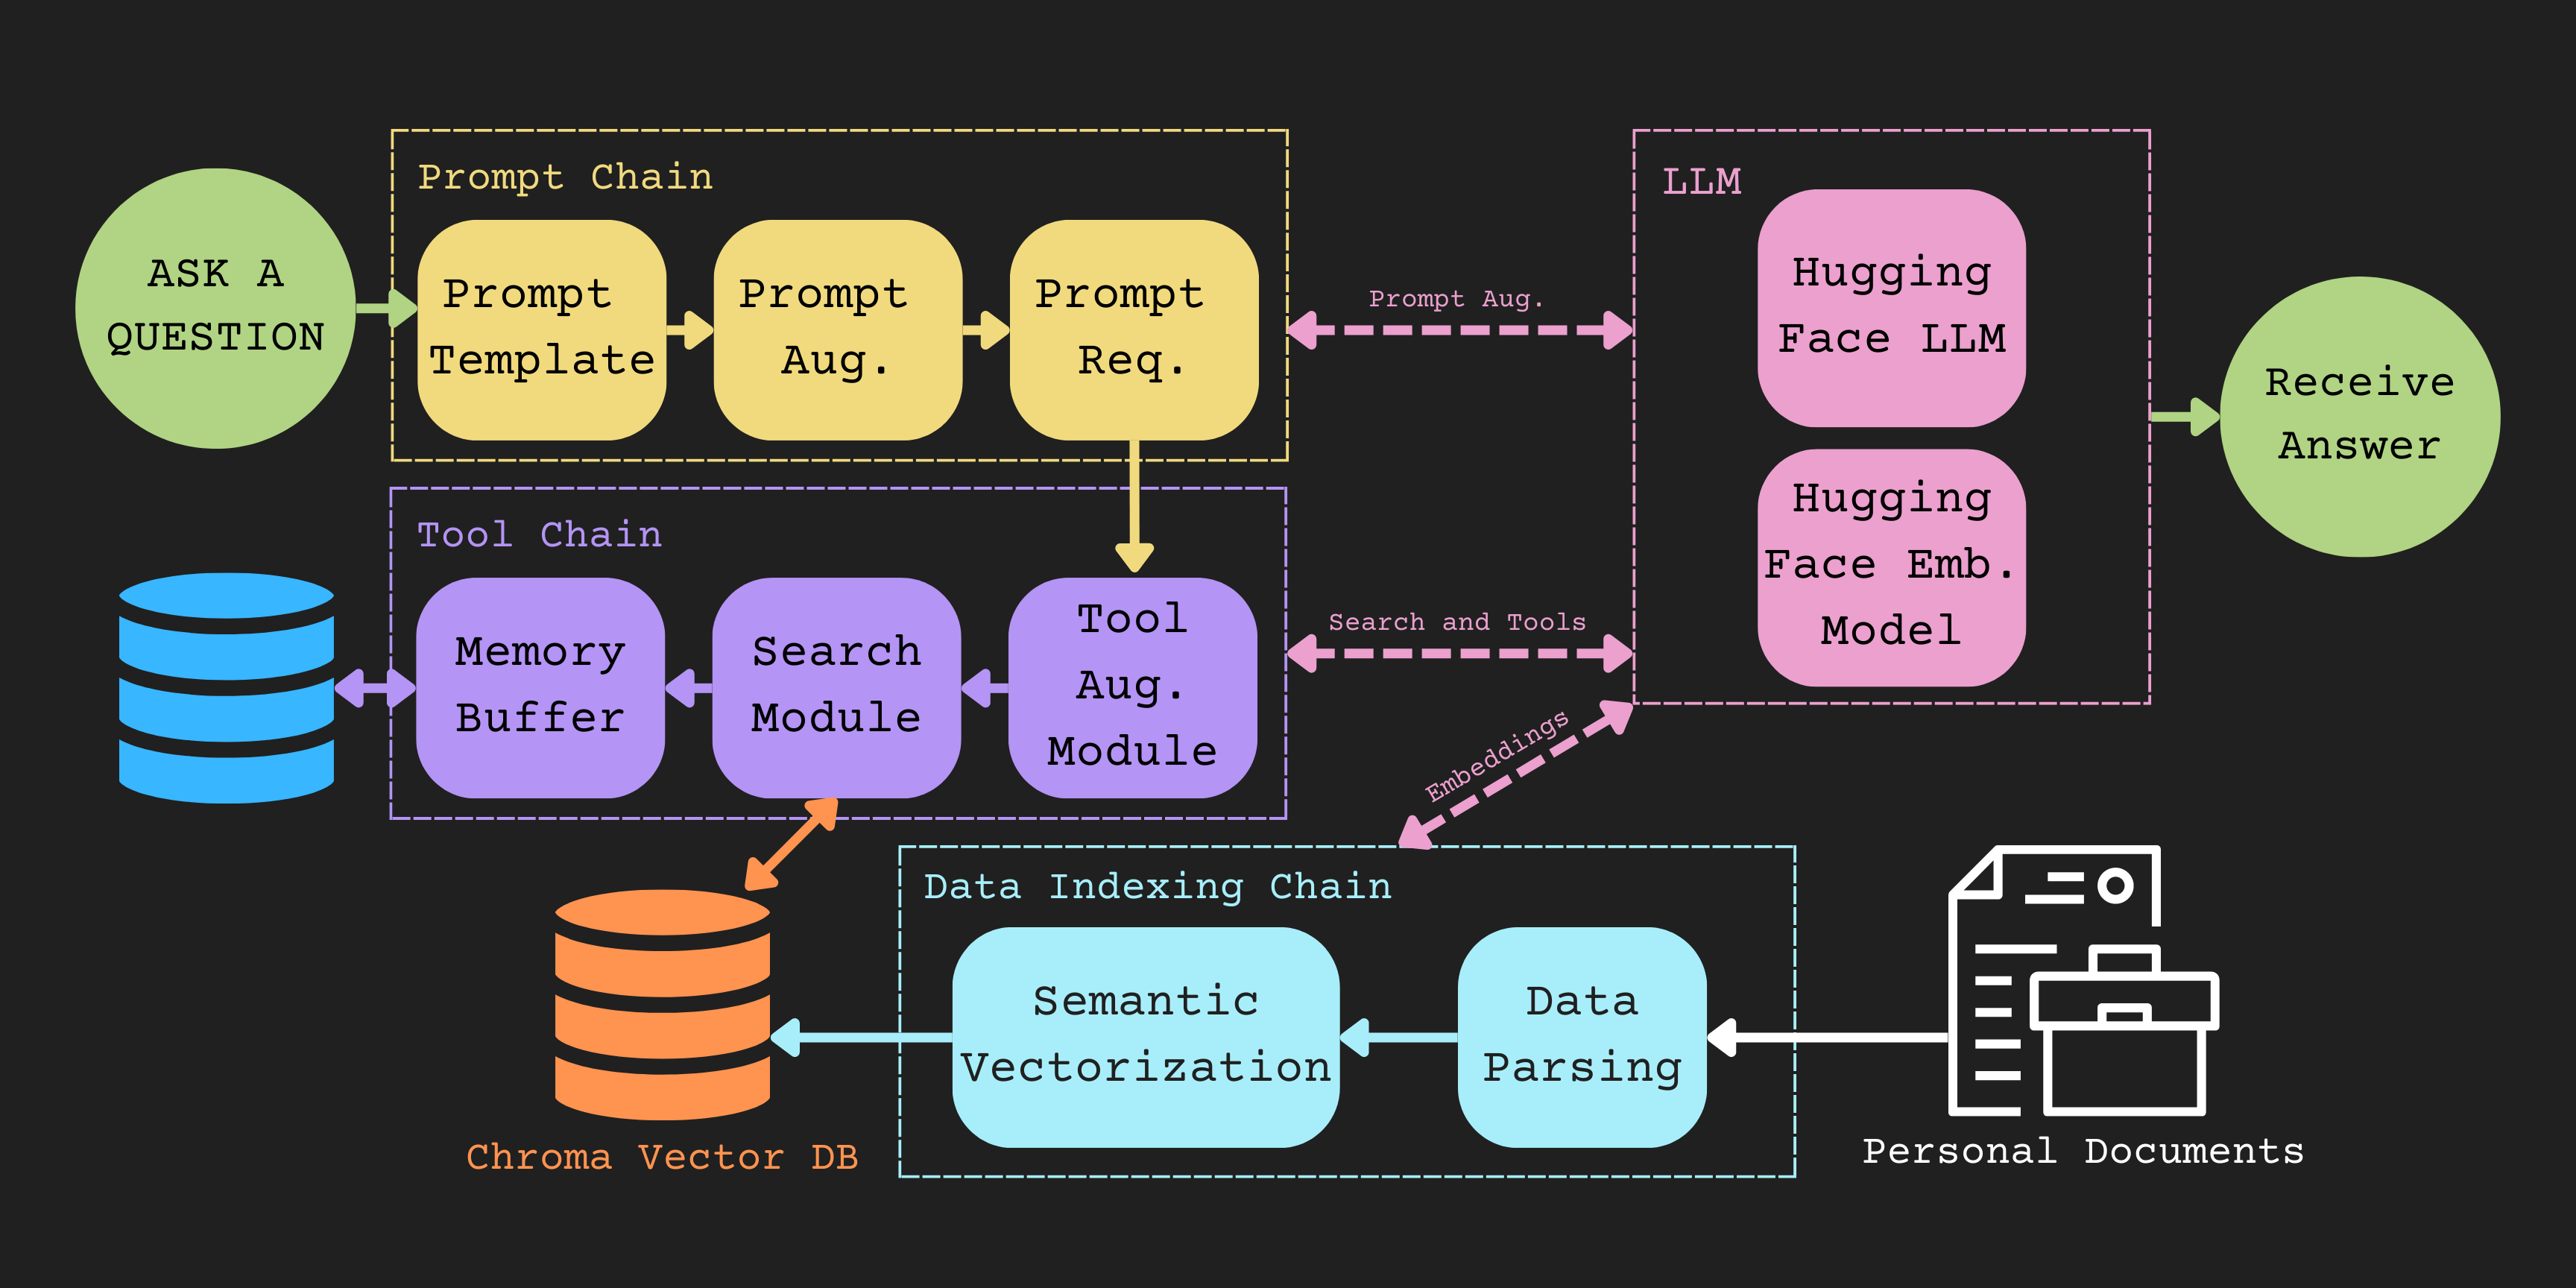

In [1]:
!pip install openai langchain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.8 MB/s eta 0:00:00


### Loading Source Data

We'll be focusing on this section of the diagram for our data.

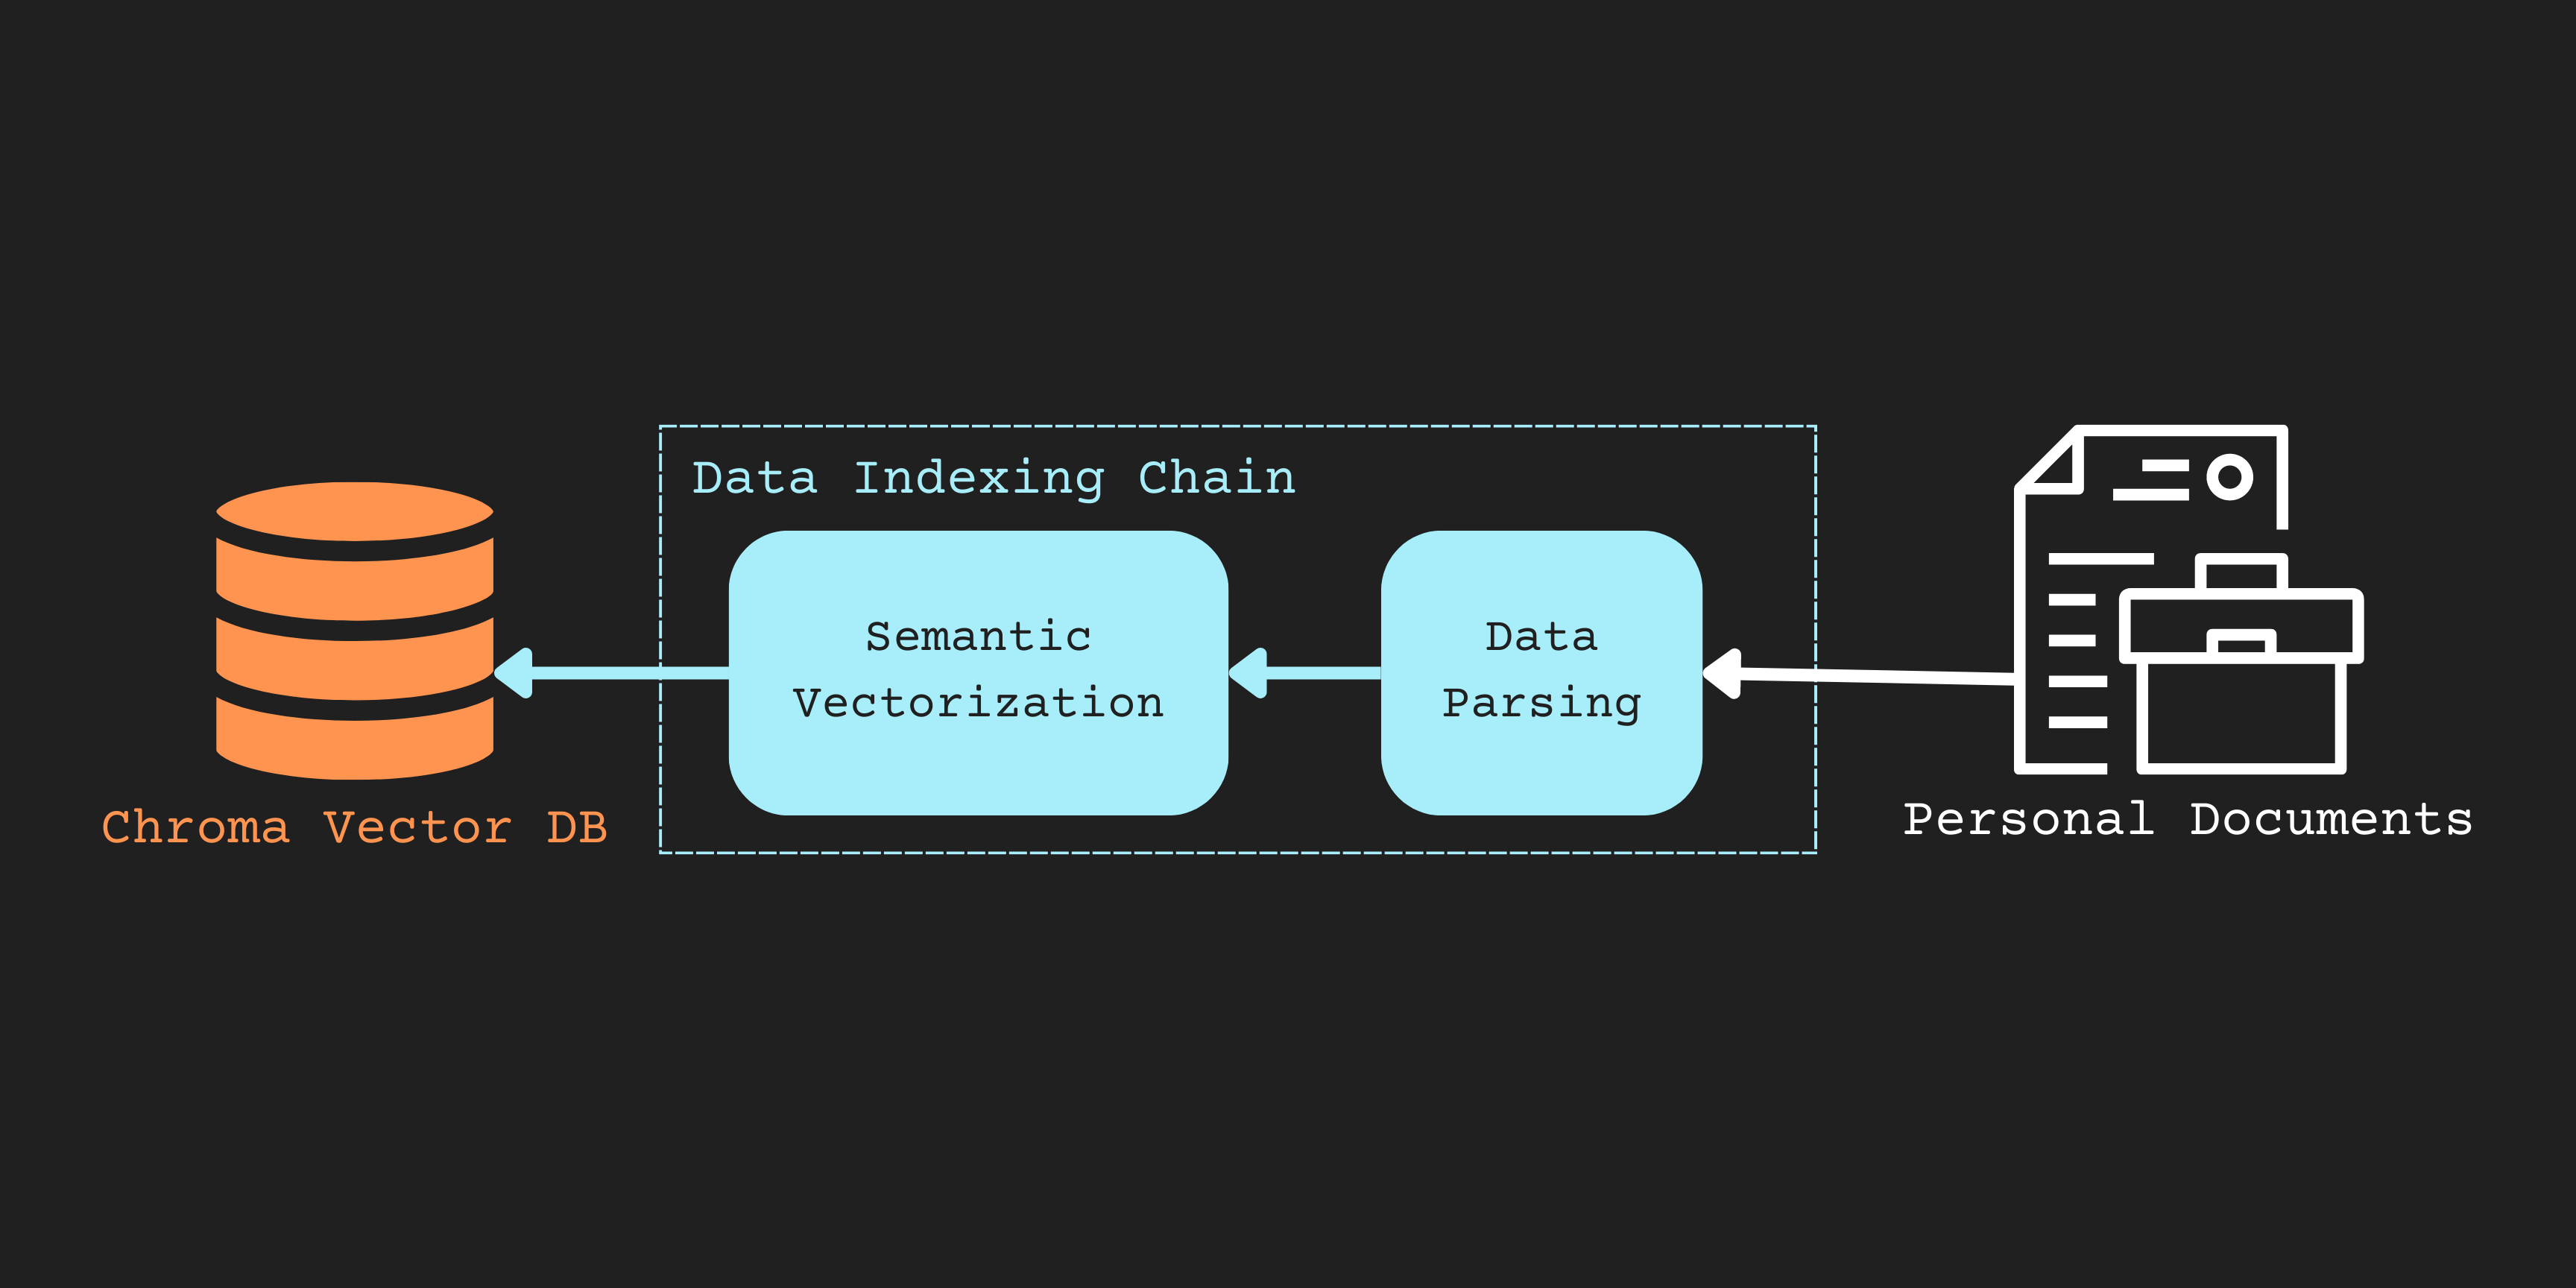

In order to get started, we'll first need a number of documents that we want to collect and manage.

We'll start with a number of HTML documents provided by [TheMITTech/shakespeare](https://github.com/TheMITTech/shakespeare).

Let's clone that repository to get started!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from langchain.document_loaders import TextLoader, DirectoryLoader
cvpr_path = "./drive/MyDrive/cvpr_papers/text/part1"
dir_loader = DirectoryLoader(cvpr_path, loader_cls=TextLoader)
cvpr_data = dir_loader.load()

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(cvpr_data)

In [22]:
documents

[Document(page_content='Minimizing the Accumulated Trajectory Error to Improve Dataset Distillation\nJiawei Du1,5,2†,Yidi Jiang2†,Vincent Y. F. Tan3,2,Joey Tianyi Zhou1,5*,Haizhou Li4,2\n1Centre for Frontier AI Research (CFAR), Agency for Science, Technology and Research (A*STAR), Singapore\n2Department of Electrical and Computer Engineering, National University of Singapore\n3Department of Mathematics, National University of Singapore\n4SRIBD, School of Data Science, The Chinese University of Hong Kong, Shenzhen, China\n5Institute of High Performance Computing (IHPC), Agency for Science, Technology and Research (A*STAR), Singapore\n{dujiawei,yidi jiang }@u.nus.edu, vtan@nus.edu.sg, Joey.tianyi.zhou@gmail.com\nAbstract\nModel-based deep learning has achieved astounding suc-\ncesses due in part to the availability of large-scale real-world\ndata. However, processing such massive amounts of data\ncomes at a considerable cost in terms of computations, stor-\nage, training and the search f

In [5]:
import os

os.environ["OPENAI_API_KEY"] = ""

In [6]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [8]:
!pip install chromadb -q
!pip install chromadb tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━

In [9]:
from langchain.vectorstores import Chroma

persist_directory = './drive/MyDrive/cvpr_openal_vector_db_2'

vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

In [7]:
from langchain.vectorstores import Chroma

persist_directory = './drive/MyDrive/vector_db'
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

In [12]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

First up, let's load our model!

Now let's set up our document vector store as a Retriever tool so we can leverage it in our chain!

In [10]:
doc_retriever = vectordb.as_retriever()

With that set-up, we're good to set-up our RetrievalQA chain and leverage all the documents we have in our Vector DB!

In [13]:
from langchain.chains import RetrievalQA

cvpr2023_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

Let's test it out by itself!

In [14]:
cvpr2023_qa.run("Could you summarize Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation?")

'The paper focuses on improving the robustness of semantic segmentation to motion-blur. It introduces a Class-Centric Motion-Blur Augmentation (CCMBA) strategy that leverages segmentation map annotations to introduce blur in specific regions of the image. This strategy aims to enhance distinguishability and easier training. The proposed method is generic and can be used with any supervised semantic segmentation network. The authors demonstrate the effectiveness of their approach on various datasets and report improved performance compared to baseline methods.'

In [16]:
cvpr2023_qa.run("What is the significant result in this Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation in cvpr 2023?")

'The significant result in the paper "Improving Robustness of Semantic Segmentation to Motion-Blur using Class-Centric Augmentation" in CVPR 2023 is the development of a Class-Centric Motion-Blur Augmentation (CCMBA) strategy. This strategy leverages segmentation map annotations to introduce blur in specific regions of the image, improving the robustness of semantic segmentation in the presence of motion-blur. The authors demonstrate the effectiveness of their approach for both CNN and Vision Transformer-based semantic segmentation networks on PASCAL VOC and Cityscapes datasets. They also show improved generalizability to real-world blur by evaluating on the GoPro and REDS deblurring datasets.'

In [17]:
cvpr2023_qa.run("What social, economic, or policy implications can be derived from Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation")

'Based on the provided context, it is not possible to directly derive specific social, economic, or policy implications from the paper "Improving Robustness of Semantic Segmentation to Motion-Blur using Class-Centric Augmentation." The paper primarily focuses on the technical aspects of improving semantic segmentation in the presence of motion blur through data augmentation techniques. It does not explicitly discuss or analyze the broader social, economic, or policy implications of this research. To understand the implications, further analysis and interpretation would be required beyond the scope of the provided context.'

In [18]:
cvpr2023_qa.run("What social, economic, or policy implications can be derived from Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation?")

'Based on the provided context, it is not possible to determine the specific social, economic, or policy implications that can be derived from the research paper "Improving Robustness of Semantic Segmentation to Motion-Blur using Class-Centric Augmentation." The paper primarily focuses on the technical aspects of improving semantic segmentation in the presence of motion blur. It does not explicitly discuss or analyze the broader social, economic, or policy implications of the proposed method.'

In [19]:
cvpr2023_qa.run("What are the limitations or constraints of Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation?")

'The given context does not provide specific information about the limitations or constraints of the proposed method.'

In [20]:
cvpr2023_qa.run("Are there any suggestions for future research or further studies of Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation?")

'The paper does not explicitly mention suggestions for future research or further studies. However, based on the findings and contributions of the paper, some potential areas for future research could include:\n\n1. Exploring different types of blur: The paper focuses on motion-blur as the specific type of degradation. Future studies could investigate the robustness of semantic segmentation to other types of blur, such as defocus blur or Gaussian blur.\n\n2. Investigating different augmentation strategies: The paper proposes a Class-Centric Motion-Blur Augmentation (CCMBA) strategy. Further studies could explore alternative augmentation strategies to improve the robustness of semantic segmentation to motion-blur or other degradations.\n\n3. Evaluating on additional datasets: The paper evaluates the proposed method on PASCAL VOC, Cityscapes, GoPro, and REDS datasets. Future research could consider evaluating the method on other benchmark datasets or real-world scenarios to further valid

In [21]:
cvpr2023_qa.run("What is the Research Question or Hypothesis in this Improving Robustness of Semantic Segmentation to Motion-Blur usingClas-Centric Augmentation?")

'The research question in this study is how to improve the robustness of semantic segmentation to motion-blur using class-centric augmentation.'

In [32]:
from IPython.display import display, Markdown
display(Markdown("The significant result in this paper is the demonstration of a novel approach to improve the robustness of semantic segmentation models to motion blur, which is a complex degradation that affects scene understanding in autonomous driving and other applications. The proposed approach, called Class-Centric Motion Blur Augmentation (CCMBA), leverages the semantic segmentation annotations to introduce blur in specific regions of the image, thereby enhancing the distinguishability between different objects and improving the model's ability to generalize to dynamic scenes. The authors show that their approach leads to improved performance compared to traditional data augmentation strategies and state-of-the-art segmentation models"))

The significant result in this paper is the demonstration of a novel approach to improve the robustness of semantic segmentation models to motion blur, which is a complex degradation that affects scene understanding in autonomous driving and other applications. The proposed approach, called Class-Centric Motion Blur Augmentation (CCMBA), leverages the semantic segmentation annotations to introduce blur in specific regions of the image, thereby enhancing the distinguishability between different objects and improving the model's ability to generalize to dynamic scenes. The authors show that their approach leads to improved performance compared to traditional data augmentation strategies and state-of-the-art segmentation models

Now, let's set-up a search tool leveraging SERP API!

You can find the process to set this up [here](https://serpapi.com/)

In [ ]:
!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [ ]:
os.environ["SERPAPI_API_KEY"] = ""

In [ ]:
from langchain.utilities import SerpAPIWrapper

search = SerpAPIWrapper()

Now we can combine those

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.llms import OpenAI
from langchain import LLMMathChain, SerpAPIWrapper

tools = [
    Tool(
        name = "Shakespeare QA System",
        func=shakespeare_qa.run,
        description="useful for when you need to answer questions about Shakespeare's works. Input should be a fully formed question."
    ),
    Tool(
        name = "SERP API Search",
        func=search.run,
        description="useful for when you need to answer questions about ruff (a python linter). Input should be a fully formed question."
    ),
]

In [ ]:
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

In [ ]:
agent.run("What is the name of Hamlet's Mother?")



> Entering new AgentExecutor chain...
I need to find the name of Hamlet's mother from Shakespeare's play.
Action: Shakespeare QA System
Action Input: Who is Hamlet's mother in the play Hamlet?
Observation: Hamlet's mother in the play Hamlet is Queen Gertrude.
Thought:I now know the final answer.
Final Answer: Queen Gertrude

> Finished chain.


'Queen Gertrude'

Now, let's add some memory to our application!

In [ ]:
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory

memory = ConversationBufferMemory(memory_key="chat_history")
readonlymemory = ReadOnlySharedMemory(memory=memory)

In order to let our Tools leverage the memory - we'll want to add the ability to read the memory to their chains!

In [ ]:
shakespeare_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever, memory=readonlymemory)

Now we can re-create our Tools list - this time using the memory capable version of the `shakespeare_qa` chain!

In [ ]:
tools = [
    Tool(
        name = "Shakespeare QA System",
        func=shakespeare_qa.run,
        description="useful for when you need to answer questions about Shakespeare's works. Input should be a fully formed question."
    ),
    Tool(
        name = "SERP API Search",
        func=search.run,
        description="useful for when you need to answer questions about ruff (a python linter). Input should be a fully formed question."
    ),
]

Let's now add some of the prompt pieces so our agent can respond exactly as we expect!

In [ ]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor

prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"

{chat_history}
Question: {input}
{agent_scratchpad}"""

prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["input", "chat_history", "agent_scratchpad"]
)

Now let's add this prompt template to our OpenAI LLM!

In [ ]:
from langchain import OpenAI, LLMChain, PromptTemplate

llm_chain = LLMChain(llm=llm, prompt=prompt)

Now we can set up our final agent!

In [ ]:
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)

Let's test this out!

In [ ]:
agent_chain.run(input="Who is Hamlet's Mother?")



> Entering new AgentExecutor chain...
Thought: I need to find information about Hamlet's mother from Shakespeare's works.
Action: Shakespeare QA System
Action Input: Who is Hamlet's mother in Shakespeare's play?
Observation: Hamlet's mother in Shakespeare's play is Queen Gertrude.
Thought:I now know the final answer.
Final Answer: Hamlet's mother is Queen Gertrude.

> Finished chain.


"Hamlet's mother is Queen Gertrude."

In [ ]:
agent_chain.run(input="What age was she in the play?")



> Entering new AgentExecutor chain...
Thought: I need to find the age of Queen Gertrude in the play Hamlet.
Action: Shakespeare QA System
Action Input: What age is Queen Gertrude in the play Hamlet?
Observation: Queen Gertrude's age is not explicitly mentioned in the play Hamlet.
Thought:I now know the final answer.
Final Answer: Queen Gertrude's age is not explicitly mentioned in the play Hamlet.

> Finished chain.


"Queen Gertrude's age is not explicitly mentioned in the play Hamlet."

In [ ]:
agent_chain.run(input="Did she live through the play?")



> Entering new AgentExecutor chain...
Thought: I need to check if Queen Gertrude survived in the play Hamlet.
Action: Shakespeare QA System
Action Input: Did Queen Gertrude survive in the play Hamlet?
Observation: Yes, Queen Gertrude survives for most of the play Hamlet. However, she eventually dies in the final act (Act 5, Scene 2) after accidentally drinking poisoned wine that was intended for Hamlet.
Thought:I now know the final answer.
Final Answer: Queen Gertrude does not live through the entire play. She dies in Act 5, Scene 2 after accidentally drinking poisoned wine.

> Finished chain.


'Queen Gertrude does not live through the entire play. She dies in Act 5, Scene 2 after accidentally drinking poisoned wine.'

### Conclusion

Here we have it!

A system capable of querying over multiple documents - all without every needing to hit an external API!